In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import sys 
from skimage import data, io, filters
import configparser
import pandas as pd 
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from matplotlib import cycler
from os.path import join as oj
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import pickle as pkl
from sklearn.preprocessing import StandardScaler,MinMaxScaler
sys.path.insert(0, "../src")

from torch import optim
from torch.utils.data import DataLoader, TensorDataset
import my_data
from utils.dice_score import dice_loss
from evaluate import evaluate
from unet import UNet
from predict import predict_img
import seaborn as sns
import pickle as pkl
from evaluate import aq_cost_function
pd.set_option('display.float_format', lambda x: '%.2f' % x)
cuda = False # torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")
config = configparser.ConfigParser()
config.read('../config.ini');
data_path =config['DATASET']['data_path'] 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
fnames = sorted([oj(config['PATHS']['model_path'] , fname) for fname in os.listdir(config['PATHS']['model_path'] ) if "pkl" in fname]) 
results_list = [pd.Series(pkl.load(open(fname, "rb"))) for fname in (fnames)] 


In [7]:
results = pd.concat(results_list, axis=1).T.infer_objects()

results.experiment_name.unique()
results['best_val_score'] = [max(x) for x in results.val_scores]

In [8]:
print(results.dataset.unique())
print(results.experiment_name.unique())

array(['Aq5'], dtype=object)

In [17]:
results = results[results.dataset == "lno"]
results = results[results.experiment_name == "Baseline"]

In [18]:
results[['experiment_name','best_val_score', 'cost_function']].groupby('cost_function').mean()

,best_val_score
cost_function,
Mean,0.97
Random,0.96


In [19]:
results[['experiment_name','best_val_score', 'cost_function']]

,experiment_name,best_val_score,cost_function
5,Baseline,0.97,Mean
9,Baseline,0.97,Mean
11,Baseline,0.97,Mean
21,Baseline,0.98,Mean
24,Baseline,0.97,Mean


In [20]:
results = results.reset_index()

In [21]:
best_idx = results.best_val_score.argmax()

In [22]:
net = UNet(int(results.num_channels[best_idx]), results.num_classes[best_idx], bilinear = results.bilinear[best_idx]).to(device)

In [23]:

# my_models = [UNet(1, 3, bilinear = results_all.bilinear[0]).to(device) for i, _ in enumerate(results.file_name)] 

net.load_state_dict(torch.load(oj(config['PATHS']['model_path'] ,results.file_name[best_idx]+".pt")))
net = net.to(device).eval()

In [24]:
x,y = my_data.load_layer_data(oj(data_path, results.dataset[best_idx]))
data_mean = x[:-4].mean()
data_std = x[:-4].std()


3


In [26]:
for i in range(1,5):
    img_idx = -i
    test_img_np  = ((x[img_idx][None, ].astype(np.float32) -data_mean)/data_std)
    with torch.no_grad():
        img_t = torch.Tensor(test_img_np).to(device)
        output = net.forward(img_t).cpu().detach().numpy()[0]

        print((y[img_idx] ==np.argmax(output, axis=0)).mean())


0.9668350219726562
0.9866828918457031
0.978001594543457
0.9634084701538086


In [27]:
img_idx = -2
test_img_np  = ((x[img_idx][None, ].astype(np.float32) -data_mean)/data_std)
with torch.no_grad():
    img_t = torch.Tensor(test_img_np).to(device)
    output = net.forward(img_t).cpu().detach().numpy()[0]


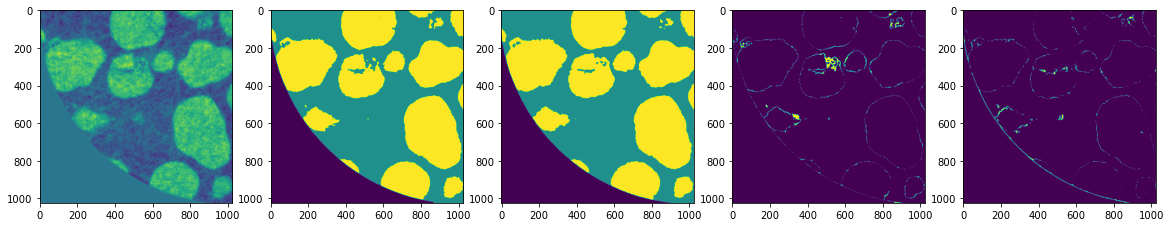

In [28]:
std_large = output.std(axis=0)<np.quantile(output.std(axis=0), .01)

fig, axes = plt.subplots(ncols = 5, figsize = (20,7))
axes[0].imshow(x[img_idx,0])
axes[1].imshow(np.argmax(output, axis=0))
axes[2].imshow(y[img_idx])
axes[3].imshow(y[img_idx] !=np.argmax(output, axis=0) )

axes[4].imshow(std_large)

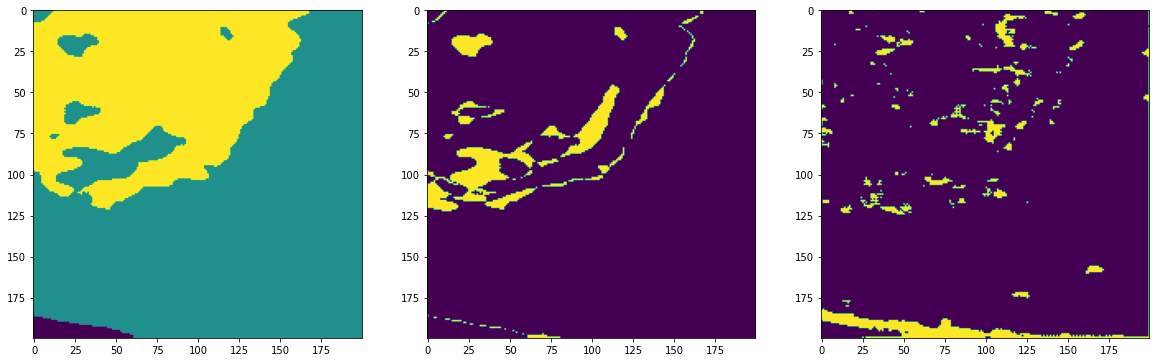

In [198]:
std_large = output.std(axis=0)<np.quantile(output.std(axis=0), .02)

fig, axes = plt.subplots(ncols = 3, figsize = (20,8))
# axes[0].imshow(x[img_idx,2])
axes[0].imshow(np.argmax(output, axis=0)[-200:,-200:])
# axes[2].imshow(show_img)
axes[1].imshow((y[img_idx] !=np.argmax(output, axis=0) )[-200:,-200:])

axes[2].imshow(std_large[-200:,-200:])

In [189]:
(y[img_idx] !=np.argmax(output, axis=0))[np.where(std_large)].mean()

0.08686198214694438

In [190]:
(y[img_idx] !=np.argmax(output, axis=0))[np.where(1-std_large)].mean() 

0.03779759634110594

In [165]:
.99*.02

0.0198

In [166]:
.01*.23

0.0023

In [178]:
(y[img_idx] ==np.argmax(output, axis=0)).mean()

0.9597492218017578

In [21]:
.

In [22]:
show_img = np.zeros_like(img_list[img_idx, 1])
show_img[np.where(img_list[img_idx, 1] ==my_data.phase_1)] =1
show_img[np.where(img_list[img_idx, 1] ==my_data.phase_2)] =2

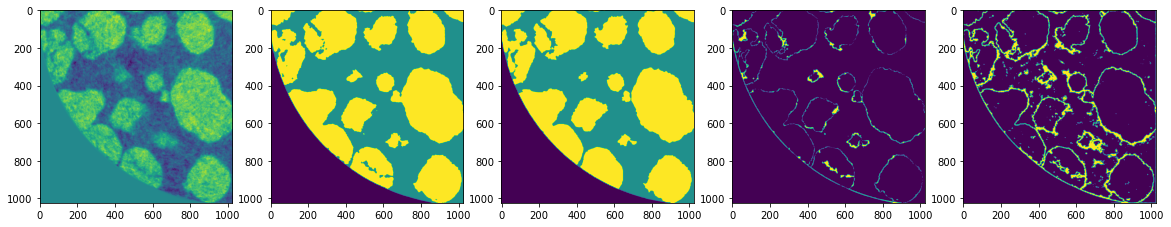

In [23]:
std_large = output.std(axis=0)<np.quantile(output.std(axis=0), .1)

fig, axes = plt.subplots(ncols = 5, figsize = (20,5))
axes[0].imshow(img_list[img_idx,0])
axes[1].imshow(np.argmax(output, axis=0))
axes[2].imshow(show_img)
axes[3].imshow(show_img !=np.argmax(output, axis=0) )

axes[4].imshow(std_large)

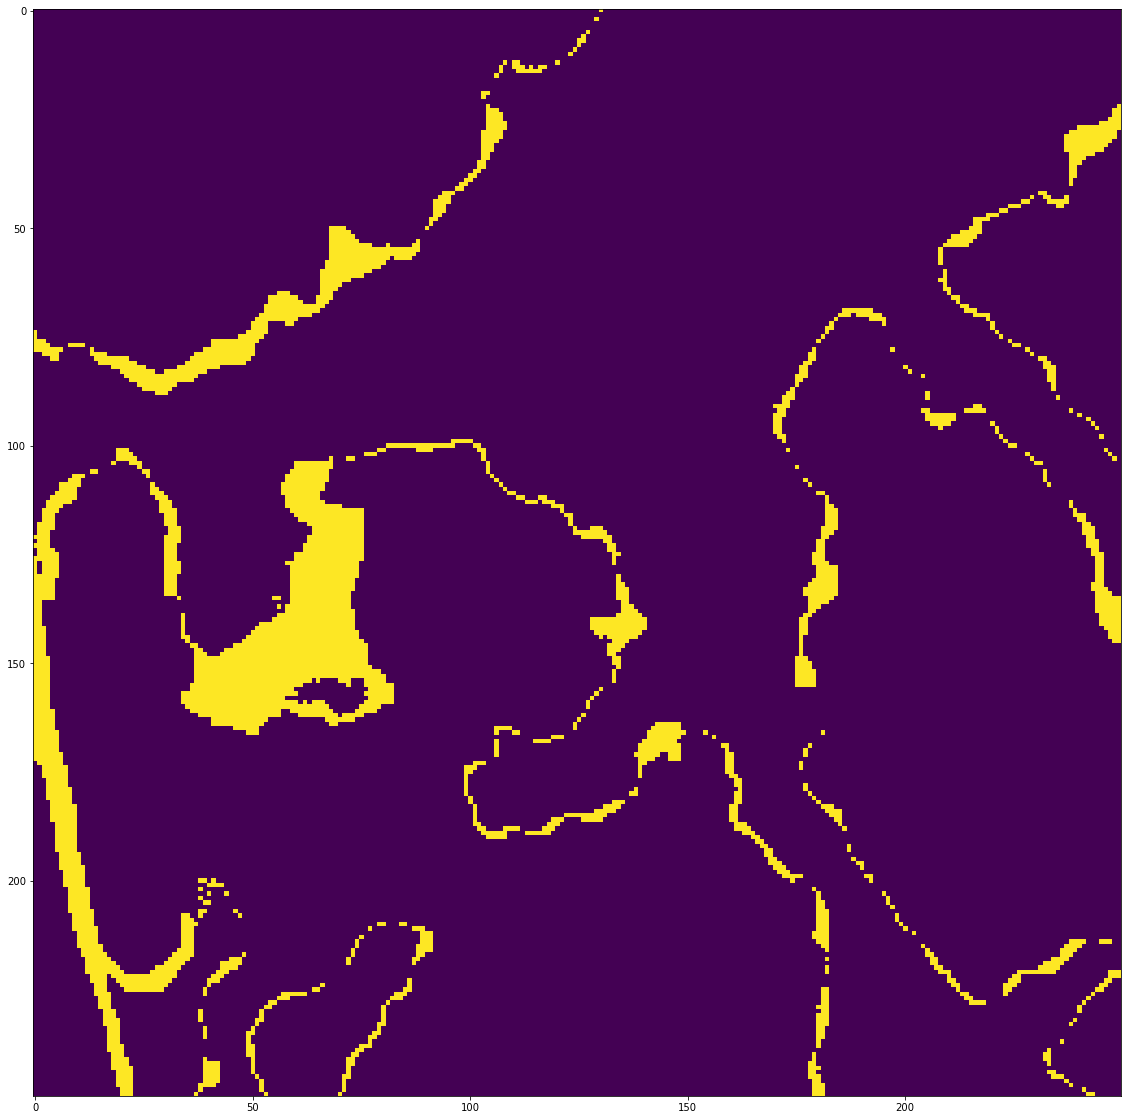

In [25]:


fig, axes = plt.subplots(figsize = (20,20))
axes.imshow((show_img !=np.argmax(output, axis=0))[:250, :250] )
